In [1]:
import os
import sys

In [2]:
# os.system('git clone https://github.com/tikendraw/caption-generator.git -q')
# os.chdir('caption-generator')

In [3]:

import os
import sys
import numpy as np
import pandas as pd
import random, math
import tensorflow as tf
import glob
import shutil
from zipfile import ZipFile
import datetime
import sys
from functools import cache
from pathlib import Path
from tqdm import tqdm
import regex as re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessing
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, TensorBoard
from model import LearningRateDecayCallback, get_model, masked_acc, masked_loss
from preprocessing import preprocess_text, embedding_matrix_creater, mapper, clean_words, clean_df
from utils import create_model_checkpoint

from config import config

from get_data import download_dataset
from funcyou.dataset import download_kaggle_dataset

from funcyou.utils import printt, dir_walk
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
from collections import Counter
import regex as re
import yaml

2023-05-20 16:53:42.154445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 16:53:43.004537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-20 16:53:44.352034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-20 16:53:44.352066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: t
2023-05-20 16:53:44.352074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: t
2023-05-20 16:53:44.352170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-05-2

In [4]:
config_file_path = './config.yaml'

# Read the config file 
with open(config_file_path, 'r') as file:
    config = yaml.safe_load(file)


RAW_CAPTION_FILE                        = config['raw_caption_file']
CAPTION_FILE                            = config['caption_file']
IMAGE_DIR                               = config['image_dir']
IMG_SIZE                                = config['img_size']
CHANNELS                                = config['channels']
IMG_SHAPE                               = config['img_shape']
MAX_LEN                                 = config['max_len']
BATCH_SIZE                              = config['batch_size']
EPOCHS                                  = config['epochs']
LEARNING_RATE                           = config['learning_rate']
UNITS                                   = config['units']
TEST_SIZE                               = config['test_size']
VALIDATION_SIZE                         = config['val_size']
EMBEDDING_DIMENSION                     = config['embedding_dimension']
GLOVE_PATH                              = config['glove_path']
D_MODEL                                 = config['d_model']
NUM_HEADS                               = config['num_heads']    
NUM_LAYERS                               = config['num_layers']    

PATCH_SIZE                              = config['patch_size']    
TRANSFORMER_LAYERS                      = config['transformer_layers']        


In [5]:
df = pd.read_csv(RAW_CAPTION_FILE, sep = '|')

# column names have spaces in them
df.columns = df.columns.str.lower().str.strip()

# dropping some values at 19999
df.drop(19999, inplace = True) #bad value at 19999

df['comment_number'] = pd.to_numeric(df['comment_number'])

#removing nulls
df.isnull().sum()
df = df.dropna()


print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 158914 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158914 non-null  object
 1   comment_number  158914 non-null  int64 
 2   comment         158914 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.8+ MB
None


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


# Curating Dataframe

### word frequency

In [6]:
# get all unique words by count
def word_count_df(x:pd.Series):
    text_data = x.str.lower().str.cat(sep=' ')
    words = word_tokenize(text_data) 
    word_count = Counter(words)
    unique_words = set(words)
    len(word_count.keys()), len(word_count.values())

    countdf = pd.DataFrame([word_count.keys(), word_count.values()]).T
    countdf.columns = ['word', 'counts']
    return countdf


In [7]:
countdf = word_count_df(df['comment'])
countdf.sort_values('counts', ascending = False).head()

,word,counts
29,a,271704
16,.,151063
13,in,83466
14,the,62978
51,on,45669


In [8]:
# removing low frequency words, they aren't contributing much
low_freq_words_df = countdf[countdf.counts<5]
print('low freq words : ',len(low_freq_words_df))
print(low_freq_words_df.word.values[:100])

low freq words :  12560
['spent' 'stitching' 'sequence' 'tractors' 'cruises' 'sifter' 'bundt'
 'fingerpaints' 'instrumentalists' 'curtained' 'portrayed' 'blitz'
 'toothpick' 'origami' 'justin' 'bieber' 'urinals' 'urinal' 'obliverate'
 'uniformly' 'colleges' 'meetings' 'checkpoint' 'advertise'
 'single-person' '4-wheeled' 'gamecube' 'picnicking' 'aross' 'mottled'
 'placards' 'belays' 'supple' 'sheared' 'spaceship' 'hutch' 'decipher'
 'tonight' 'questioning' 'frolicks' 'crampons' 'disregarding' 'slush'
 'snowmobiling' 'lucky' 'prescription' 'spectrum' 'month' 'sellers' 'jail'
 'band-aid' 'life-vest' 'black-colored' 'filler' 'lowly' 'entrees'
 'hesitates' 'suns' 'relatives' 'moutains' 'connects' 'tree-covered'
 'multiracial' 'bassoon' 'beanies' 'explained' 'somethings' 'betty' 'boop'
 'noddles' 'papayas' 'septic' 'oblong' 'whimsically' 'pantaloons'
 'cradled' 'relevance' 'cobs' 'sheath' 'unsheathes' 'riverbed' 'snapshot'
 'appetizers' 'pillow-fight' 'i-beam' 'blender' 'magizine' 'overshir

we are keeping words in comments which atleast has occured  5 times( there are unnecessary word which we don't want) 
there are ~12000 words that doesn't even gets repeated 5 times in 150000 lines

In [9]:
words_to_keep=set(countdf[countdf['counts']>4].word.values)
len(words_to_keep)

7732

 ### How many rows cantains rare words

In [10]:

def check_words_in_list(string, words):
    """
    Checks if any words in a string are not in a provided list.

    Args:
    string: The string to check.
    words: The list of words to check against.

    Returns:
    True if any words in the string are not in the provided list, False otherwise.
    """
    string = str(string).lower()
    words_in_string = set(string.split())
    words_in_list = set(words)

    return words_in_string - words_in_list != set()

In [11]:
ff = 'in the '
check_words_in_list(ff, words_to_keep)

False

In [12]:
df['has_rare_words'] = df['comment'].map(lambda x: check_words_in_list(x,words_to_keep)) # takes 40 sec

In [13]:
df.has_rare_words.value_counts()

has_rare_words
False    140722
True      18192
Name: count, dtype: int64

### Removing low frequecy words

In [14]:
# now removing words not in words_to_keep

def clean_words(x, words_to_keep):
    words = re.split(r'\W+', x)
    return ' '.join(w for w in words if w.lower() in words_to_keep)


In [15]:
df['comment'] = df['comment'].map(lambda x: clean_words(x,words_to_keep=words_to_keep))


In [16]:
df.head()

,image_name,comment_number,comment,has_rare_words
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,False
1,1000092795.jpg,1,Two young White males are outside near many bu...,False
2,1000092795.jpg,2,Two men in green shirts are standing in a yard,False
3,1000092795.jpg,3,A man in a blue shirt standing in a garden,False
4,1000092795.jpg,4,Two friends enjoy time together,True


In [17]:
df['has_rare_words2'] = df['comment'].map(lambda x: check_words_in_list(x,words_to_keep)) # takes 40 sec

In [18]:
df.has_rare_words.value_counts(), df.has_rare_words2.value_counts()

(has_rare_words
 False    140722
 True      18192
 Name: count, dtype: int64,
 has_rare_words2
 False    158914
 Name: count, dtype: int64)

we removed the rare words

### Adding start and end token


In [19]:
# adding start and end token

START_TOKEN = 'startseq'
END_TOKEN = 'endseq'

df['comment'] = START_TOKEN + ' ' + df['comment'] + ' ' + END_TOKEN

# image_path
df['image_path'] = str(IMAGE_DIR) + '/' + df['image_name']

# word_length
df['sent_length'] = df['comment'].apply(lambda x: len(str(x).split()))


In [20]:
df['img_exists'] = df['image_path'].apply(lambda x: os.path.isfile(x))

In [21]:
df.head()

,image_name,comment_number,comment,has_rare_words,has_rare_words2,image_path,sent_length,img_exists
0,1000092795.jpg,0,startseq Two young guys with shaggy hair look ...,False,False,input/flickr30k/images/1000092795.jpg,18,True
1,1000092795.jpg,1,startseq Two young White males are outside nea...,False,False,input/flickr30k/images/1000092795.jpg,11,True
2,1000092795.jpg,2,startseq Two men in green shirts are standing ...,False,False,input/flickr30k/images/1000092795.jpg,12,True
3,1000092795.jpg,3,startseq A man in a blue shirt standing in a g...,False,False,input/flickr30k/images/1000092795.jpg,12,True
4,1000092795.jpg,4,startseq Two friends enjoy time together endseq,True,False,input/flickr30k/images/1000092795.jpg,7,True


### Sentence length distribution

<AxesSubplot: ylabel='Frequency'>

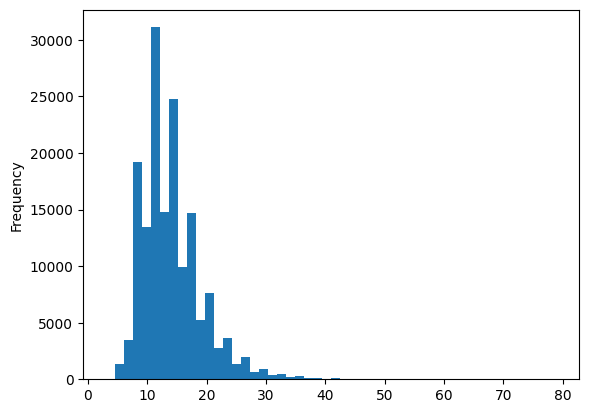

In [22]:
df.sent_length.plot(kind='hist', bins = 50)

In [23]:
np.percentile(df.sent_length, 99.96)

50.0

In [24]:
MAX_LEN = 50 # It covers more than 98.5% of the data

### **For the Sake of COmputation power and time we will train with one caption per image rather than 5 caption per image**

In [25]:
df.shape

(158914, 8)

Finding median sentence length for all class of comment numbers, to ensure that our MAX_LEN covers all of them

In [26]:

# Group by a categorical column
grouped = df.select_dtypes(include=['float64', 'int64']).groupby('comment_number')


# Apply aggregation functions on numerical columns
aggregated = grouped.agg(['mean', 'median', 'min', 'max', 'count'])
aggregated

sent_length                      
                      mean median min max  count
comment_number                                  
0                19.871472   19.0   6  79  31783
1                15.859485   15.0   6  41  31783
2                13.603027   13.0   4  34  31783
3                11.771922   11.0   4  36  31783
4                 9.871846   10.0   3  38  31782

In [27]:
# i randomly chose 2nd comment of all picture you can chose anything bw 0 to 4
df= df[(df.comment_number==1) & (df.img_exists==True)&(df.sent_length<51)]
df.shape

(31783, 8)

now we are just using 1/5 dataset

# Tokenize

In [28]:
def preprocess_text(text):

    text = tf.strings.lower(text)

    text = tf.strings.regex_replace(text, r'\d', '')

    # Remove any punctuations
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(
        '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

    # Remove single characters
    text = tf.strings.regex_replace(text, r'\b\w\b', '')
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    return text


In [29]:

#tokenizer
tokenizer = TextVectorization(standardize=preprocess_text)
tokenizer.adapt(df['comment'])


word_to_id = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)


In [30]:
# # load image model
# vgg = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE))

# vgg.trainable = False

# making Dataset

In [31]:

def mapper(x, y, tokenizer):
    x = load_images_now(x)
    y = tokenizer(y)

    y_in = y[:-1]
    y_in =  tf.pad(y_in, [[0, MAX_LEN - tf.shape(y_in)[0]]] , constant_values=0)

    y_out = y[1:]
    y_out =  tf.pad(y_out, [[0, MAX_LEN - tf.shape(y_out)[0]]], constant_values=0)

    return (x, y_in), y_out


@tf.function
def load_images_now(x):
    image_data = tf.io.read_file(x)
    image_features = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image_features = tf.image.resize_with_pad(
        image_features, target_height=IMG_SIZE, target_width=IMG_SIZE)
    return image_features


In [32]:
# Trying to match max_len* units to output of vgg16 output( for attention layer)
# for i in range(1,51):
#     calc = 8*8*512/MAX_LEN*8*i
#     print(f'{calc:>20} : {i}')
#     if calc % 1==0:
#         print(f'{i} is chosen one')
#         print(MAX_LEN)

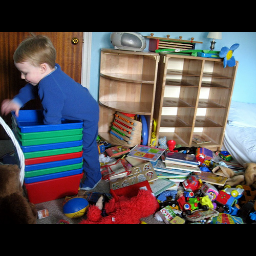

In [33]:
random_image_filepath = df['image_path'].sample(1).values[0]

p_image = load_images_now(random_image_filepath)

array_to_img(p_image)


In [34]:
# Creating dataset
TEST_SIZE = config['test_size']
VAL_SIZE =  config['val_size']

train, val = train_test_split(
    df[['image_path', 'comment']],  test_size=VAL_SIZE, random_state=11)
train, test = train_test_split(
    train[['image_path', 'comment']],  test_size=TEST_SIZE, random_state=11)


train_data = tf.data.Dataset.from_tensor_slices((train.image_path, train.comment))
test_data = tf.data.Dataset.from_tensor_slices((test.image_path, test.comment))
val_data = tf.data.Dataset.from_tensor_slices((val.image_path, val.comment))


train_data = train_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data =   test_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data =     val_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# resnet_output_flattened_shape = 8*8*2048

print("Number of training samples: %d" %
      tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" %
      tf.data.experimental.cardinality(val_data))
print("Number of test samples: %d" %
      tf.data.experimental.cardinality(test_data))

VOCAB_SIZE = tokenizer.vocabulary_size()
print("Vocabulary size: %d" % VOCAB_SIZE)


Number of training samples: 3586
Number of validation samples: 199
Number of test samples: 189
Vocabulary size: 7104


2023-05-20 16:55:12.981456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]
2023-05-20 16:55:13.051438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]
2023-05-20 16:55:13.117991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]


In [35]:
train.shape, len(train_data)*BATCH_SIZE

((28683, 2), 28688)

In [36]:
for (img_in, txt_in), txt_out in train_data.take(1):
    # print(f'{i.numpy().decode():<40} {j.numpy()}')
    print('x     : ', img_in.shape)
    print('y_in.shape(one batch)  : ', txt_in.shape)
    
    print('y_in  : ', txt_in[0])
    
    print('y_out.shape(one batch)  : ', txt_out.shape)
    print('y_out : ', txt_out[0])
    print('\n')


x     :  (8, 256, 256, 3)
y_in.shape(one batch)  :  (8, 50)
y_in  :  tf.Tensor(
[   2 1710   31    8  580    6    4  192   11   56    9  326  251    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
y_out.shape(one batch)  :  (8, 50)
y_out :  tf.Tensor(
[1710   31    8  580    6    4  192   11   56    9  326  251    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)




2023-05-20 16:55:13.229601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [28683]
	 [[{{node Placeholder/_1}}]]


# Model

In [37]:
print(f'{UNITS=} {MAX_LEN=} {BATCH_SIZE=} {VOCAB_SIZE}')

UNITS=16 MAX_LEN=50 BATCH_SIZE=8 7104


In [39]:
!ls

/bin/bash: /home/t/miniconda3/envs/tf_new/lib/libtinfo.so.6: no version information available (required by /bin/bash)
caption-generator-for-kaggle.ipynb  libdevice.10.bc
captiongenerator_notebook.ipynb     local_config_cuda
checkpoints			    main.py
config.py			    model.py
config.yaml			    preprocessing.py
data				    __pycache__
embedding			    train.ipynb
Evaluate.txt			    transformer_in_making.ipynb
funcyou				    transformer.png
get_data.py			    transformer.py
input				    utils.py


In [38]:
from transformer import CaptionGenerator

NameError: name 'image_size' is not defined

In [ ]:
model = get_model()
print(model.summary())

image_input:  (None, 8, 512)
Dense:  (None, 3600)
reshape:  (None, 30, 120)
dense concat:  (None, 30, 240)
txt_input:  (None, 30)
text_embedding:  (None, 30, 50)
enc dropout:  (None, 30, 50)
decoder output:  (None, 30, 240)
decoder dropout:  (None, 30, 240)
attention:  (None, 30, 240)
concat:  (None, 30, 480)
concat dropout:  (None, 30, 480)
Dense3_final:  (None, 30, 6830)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 8, 512)]     0           []                               
                                                                                                  
 embedding (Emb

In [ ]:

def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    matchh = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(matchh)/tf.reduce_sum(mask)


In [ ]:
print(LEARNING_RATE)

0.01


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=masked_loss,
              metrics=[masked_acc])


In [ ]:
model.load_weights(f'model_weights/best_so_far/')

In [ ]:
os.makedirs('log', exist_ok=True)
csv_logger = CSVLogger('./log/training.log',append=True )
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
EPOCHS = 360
print(len(train_data) // EPOCHS, len(val_data) // EPOCHS)

# steps_per_epoch = int(1*(len(train_data) / EPOCHS))
# validation_steps =  int(1*(len(val_data) / EPOCHS))
# print(steps_per_epoch, validation_steps)

steps_per_epoch = 20
validation_steps = 1
print(steps_per_epoch, validation_steps)


9 0
20 1


In [ ]:
len(train_data), len(val_data), len(test_data)

(3586, 199, 189)

In [ ]:
{"expected_loss": np.log(VOCAB_SIZE),
 "expected_acc": 1/VOCAB_SIZE}

{'expected_loss': 8.829079952564836, 'expected_acc': 0.00014641288433382137}

## model.fit

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=EPOCHS,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[
                        # decay_callback,
                        csv_logger,
                        create_model_checkpoint(model_name = 'capgen', save_dir = 'checkpoints', monitor = 'masked_acc'),
                        tensorboard_callback
                                ]
                    )

Epoch 1/360
20/20 [==============================] - 120s 5s/step - loss: 8.8291 - masked_acc: 0.0012 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 2/360
20/20 [==============================] - 63s 3s/step - loss: 8.8291 - masked_acc: 0.0000e+00 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 3/360
20/20 [==============================] - 68s 4s/step - loss: 8.8291 - masked_acc: 0.0011 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 4/360
20/20 [==============================] - 64s 3s/step - loss: 8.8291 - masked_acc: 0.0000e+00 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 5/360
20/20 [==============================] - 71s 4s/step - loss: 8.8291 - masked_acc: 0.0011 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 6/360
20/20 [==============================] - 68s 4s/step - loss: 8.8291 - masked_acc: 0.0000e+00 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 7/360
20/20 [==============================] - 68s 4s/step - loss: 8.8315 - masked_acc:

KeyboardInterrupt: 

In [ ]:
from funcyou.plot import plot_history

In [ ]:
plot_history(history,plot = ['loss','masked_acc'], split = ['train','val'], )

NameError: name 'history' is not defined

In [ ]:
# %tensorboard --logdir logs/gradient_tape


## Saving the Model

In [ ]:
from datetime import datetime

In [ ]:
# model.save(f'saved_model/best-{datetime.now()}-{EPOCHS}.h5')
# model.save_weights(f'model_weights/best_so_far_final/')

In [ ]:
!ls saved_model

In [ ]:
!ls -la -h 'saved_model/'

# Prediction

In [ ]:
pred = model.predict(test_data.take(1))
print(pred.shape)

In [ ]:
ppred = tf.argmax(pred, axis = -1)
print(ppred.shape)

In [ ]:
for i in ppred:
    print(tf.strings.join(id_to_word(i), ' ').numpy())
    print('')